In [2]:
import cv2
import pandas as pd
import numpy as np
import os
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report, confusion_matrix, precision_score, recall_score, f1_score
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import RocCurveDisplay
from sklearn.metrics import PrecisionRecallDisplay
from sklearn.model_selection import GridSearchCV, KFold
from sklearn.svm import SVC
import joblib
from skimage.util import view_as_windows
from scipy.fftpack import dct
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier

### Helper Functions for feature extraction


In [5]:
def get_patches(image_mat):
    """
    Extract patches from an image
    :param image_mat: The image as a matrix
    :returns: The patches
    """
    stride = 8  # stride is same as window's breadth so that it gives non-overlapping blocks.
    window_shape = (8, 8)
    image_mat = np.array(image_mat)

    windows = view_as_windows(image_mat, window_shape, step=stride)
    patches = []
    for m in range(windows.shape[0]):
        for n in range(windows.shape[1]):
            patches += [windows[m][n]]
    return patches

def std_and_ones(type_of_sub_image_blocks):
    """
    

    Args:
        type_of_sub_image_blocks (_type_): _description_

    Returns:
        _type_: _description_
    """
    ac_dct_stack = []
    number_of_ones = []

    for block in type_of_sub_image_blocks:
        dct_block = dct(block, type=2, n=None, axis=-1, norm=None, overwrite_x=False)
        dct_block_row = dct_block.flatten()  # 2d dct array to 1d row array.
        ac_dct = dct_block_row[1:]  # only AC component, removing the first DC comp.
        ac_dct_stack.append(ac_dct)

    ac_dct_stack = np.asarray(ac_dct_stack)  # 1536X63
    ac_dct_stack = ac_dct_stack.T  # 63X1536

    ac_dct_std = np.std(ac_dct_stack, axis=1)  # row wise standard-deviation.

    for i in range(ac_dct_stack.shape[0]):
        count_one = 0
        for j in range(ac_dct_stack.shape[1]):
            if ac_dct_stack[i][j] > 0:  # row wise counting number of ones.
                count_one += 1
        number_of_ones.append(count_one)

    number_of_ones = np.asarray(number_of_ones)

    return ac_dct_std, number_of_ones

def extract_sift_features(image):
    """_summary_

    Args:
        image (_type_): _description_

    Returns:
        _type_: _description_
    """
    if image is None or len(image.shape) != 3 or image.shape[2] != 3:
        return np.zeros(128)  # Return array of zeros if image is invalid

    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    sift = cv2.SIFT_create()
    keypoints, descriptors = sift.detectAndCompute(gray_image, None)
    
    if descriptors is not None:
        if len(descriptors) >= 128:
            print(descriptors)
            return descriptors[:128].flatten()  # Keep only the first 128 elements
        else:
            # Fill the remaining descriptors with zeros
            filled_descriptors = np.zeros((128, descriptors.shape[1]))
            filled_descriptors[:len(descriptors)] = descriptors
            print(filled_descriptors)
            return filled_descriptors.flatten()
    else:
        return np.zeros(128)  # Return array of zeros if no descriptors found
def feature_sub_image(sub_image):
    """_summary_

    Args:
        sub_image (_type_): _description_

    Returns:
        _type_: _description_
    """
    sub_image_blocks = get_patches(sub_image)  # Gives the 8x8 patches/blocks of sub_image.

    sub_image_cropped = sub_image[4:, 4:]  # removing 4 rows and 4 cols.
    sub_image_cropped_blocks = get_patches(sub_image_cropped)

    STD_full_image, ONE_full_image = std_and_ones(sub_image_blocks)
    STD_cropped_image, ONE_cropped_image = std_and_ones(sub_image_cropped_blocks)

    F_sub_image = np.column_stack((STD_full_image, ONE_full_image, STD_cropped_image, ONE_cropped_image))

    F_sub_image_flat = F_sub_image.T.flatten()  # column wise flattening, 63*4=252 features
    return F_sub_image_flat

def feature_extraction(path_to_folder, class_label):
    data_list = []
    for file_name in os.listdir(path_to_folder):
        path_to_img = os.path.join(path_to_folder, file_name)
        img = cv2.imread(path_to_img)

        if np.shape(img) == ():
            continue

        img = cv2.cvtColor(img, cv2.COLOR_BGR2YCrCb)  # changing to YCrCb color space.
        img_y = img[:, :, 0]  # the Y channel only.
        img_cr = img[:, :, 1]  # the Cr channel only.
        img_cb = img[:, :, 2]  # the Cb channel only.

        Fy = feature_sub_image(img_y)
        Fcr = feature_sub_image(img_cr)
        Fcb = feature_sub_image(img_cb)

        sift_features = extract_sift_features(img)

        # Keep only the first 756 DCT features and first 128 SIFT features
        final_feature = np.concatenate((Fy[:756], Fcb[:756], Fcr[:756], sift_features[:128]), axis=None)
        
        final_feature = list(final_feature)
        final_feature.insert(0, file_name)
        final_feature.insert(1, class_label)
        data_list.append(final_feature)

    return data_list


### Feature Extracion

In [6]:
# #CASIA V1.0 dataset
from skimage.util.shape import view_as_windows
from scipy.fftpack import dct
from sklearn.preprocessing import MinMaxScaler

au_path = "Casia1/Au/Au"
tp_path1 = "Casia1/Tp/Tp/CM"
tp_path2 = "Casia1/Tp/Tp/Sp"
output_name='CASIA1_features_884.csv'

data_list1 = feature_extraction(au_path, 0)
data_list2 = feature_extraction(tp_path1, 1)
data_list3 = feature_extraction(tp_path2, 1)

df = pd.DataFrame(data_list1 + data_list2 + data_list3)
df.shape


[[ 6. 14. 31. ...  0.  0.  0.]
 [34.  1.  0. ...  6.  8.  0.]
 [ 8.  0.  0. ...  5. 20. 88.]
 ...
 [ 0.  0.  0. ...  0.  0.  0.]
 [ 0.  0.  0. ...  0.  0.  0.]
 [ 0.  0.  0. ...  0.  0.  0.]]
[[ 0.  0.  0. ...  3. 23.  8.]
 [ 2.  3. 23. ...  0.  0.  0.]
 [ 4.  0.  0. ...  0.  0.  0.]
 ...
 [ 0.  0.  0. ...  0.  0.  0.]
 [ 0.  0.  0. ...  0.  0.  0.]
 [ 0.  0.  0. ...  0.  0.  0.]]
[[ 99.  25.  14. ...   5.   3.  14.]
 [  5.   8.  18. ...   7.   7.  20.]
 [ 24.   3.   0. ... 105.  29.   0.]
 ...
 [  0.   0.   0. ...   0.   0.   0.]
 [  0.   0.   0. ...   0.   0.   0.]
 [  0.   0.   0. ...   0.   0.   0.]]
[[37. 12. 12. ...  3.  3.  5.]
 [ 0.  0.  0. ...  0.  0.  0.]
 [ 0.  0.  0. ...  0.  0.  0.]
 ...
 [ 0.  0.  0. ...  0.  0.  0.]
 [ 0.  0.  0. ...  0.  0.  0.]
 [ 0.  0.  0. ...  0.  0.  0.]]
[[ 2.  1.  8. ...  0.  2. 26.]
 [ 0.  0. 10. ...  3.  2.  1.]
 [ 0.  0.  0. ...  0.  2. 17.]
 ...
 [ 0.  0.  0. ...  0.  0.  0.]
 [ 0.  0.  0. ...  0.  0.  0.]
 [ 0.  0.  0. ...  0.  0.  0.]]
[[ 1

(1720, 886)

##### Save the csv

In [7]:
df.to_csv(output_name, index=False)

In [9]:
# delete the data_list to free up memory
del data_list1
del data_list2
del data_list3
del df

In [12]:
df = pd.read_csv(output_name)

NameError: name 'output_name' is not defined

In [11]:
df

,0,1,2,3,4,5,6,7,8,9,...,876,877,878,879,880,881,882,883,884,885
0,Au_nat_0073.jpg,0,184.396446,135.558199,107.691206,78.218373,61.425199,46.497519,30.723724,1061.103333,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,Au_arc_0052.jpg,0,107.876702,80.185003,63.881898,53.567996,40.114938,33.192927,23.222693,894.122036,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,Au_txt_0084.jpg,0,157.262132,77.823184,52.441608,43.702119,31.171785,25.071050,20.294229,734.977483,...,0.0,0.0,0.0,0.0,1.0,27.0,14.0,0.0,0.0,0.0
3,Au_sec_0088.jpg,0,162.059121,118.535658,124.004450,99.770224,59.140197,38.159992,22.060530,816.414324,...,15.0,5.0,15.0,22.0,22.0,7.0,2.0,3.0,23.0,8.0
4,Au_ani_0015.jpg,0,119.462571,75.881277,64.110761,49.322930,37.486348,29.379852,23.941348,613.074467,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1715,Sp_D_NNN_A_arc0072_pla0097_0294.jpg,1,147.445520,91.625699,75.966409,61.840240,53.326499,46.335963,34.110987,1024.094926,...,0.0,2.0,95.0,72.0,2.0,1.0,2.0,13.0,12.0,6.0
1716,Sp_D_NRN_A_cha0051_art0014_0459.jpg,1,130.897697,80.561289,59.949019,41.981852,36.431924,22.188503,20.868081,1358.321226,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1717,Sp_D_NRN_A_cha0018_art0013_0458.jpg,1,228.756307,162.872417,130.996167,105.903870,90.851603,74.742178,55.068097,807.488045,...,17.0,26.0,0.0,0.0,0.0,1.0,102.0,60.0,10.0,7.0
1718,Sp_D_NRN_A_ani0057_art0076_0438.jpg,1,109.702942,80.502335,65.867929,53.809205,45.884865,35.633185,26.229080,689.145204,...,9.0,24.0,67.0,32.0,0.0,0.0,17.0,8.0,4.0,3.0


### Drop the image_names and Labels



In [4]:
array=df.values
x_feature=array[:,2:]
y_label=array[:,1].astype('int')

In [5]:
print("Features shape: ", x_feature.shape)
print("Labels shape: ", y_label.shape)

Features shape:  (1720, 884)
Labels shape:  (1720,)


In [6]:
X_train, X_test, Y_train, Y_test = train_test_split(x_feature, y_label, test_size=0.25, random_state=42)

## Training the SVM model

In [18]:
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
from sklearn.preprocessing import PowerTransformer
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold
from sklearn.metrics import classification_report, confusion_matrix, precision_score, recall_score, f1_score
import seaborn as sns
import matplotlib.pyplot as plt

#### Create a pipeline and search for best params

In [20]:
pipe = Pipeline([
    ('pt', PowerTransformer(method='yeo-johnson', standardize=True)),  # Step 1: Apply Power Transformation
    ('svc', SVC(probability=True))  # Step 2: Train the SVM model
])

# Define the parameter grid for GridSearchCV
param_grid = {
    'svc__C': [1, 10, 100, 500, 1000],
    'svc__gamma': [1, 0.1, 0.01, 0.001, 0.0001],
    'svc__kernel': ['rbf']
}

# Initialize GridSearchCV
grid = GridSearchCV(pipe, param_grid=param_grid, scoring='accuracy', cv=KFold(n_splits=10), verbose=3)

# Fit the pipeline with GridSearchCV
grid_result = grid.fit(X_train, Y_train)

# Print the best parameters found
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))


Fitting 10 folds for each of 25 candidates, totalling 250 fits
[CV 1/10] END svc__C=1, svc__gamma=1, svc__kernel=rbf;, score=0.566 total time=   6.9s
[CV 2/10] END svc__C=1, svc__gamma=1, svc__kernel=rbf;, score=0.488 total time=   6.8s
[CV 3/10] END svc__C=1, svc__gamma=1, svc__kernel=rbf;, score=0.535 total time=   6.8s
[CV 4/10] END svc__C=1, svc__gamma=1, svc__kernel=rbf;, score=0.488 total time=   6.8s
[CV 5/10] END svc__C=1, svc__gamma=1, svc__kernel=rbf;, score=0.504 total time=   6.8s
[CV 6/10] END svc__C=1, svc__gamma=1, svc__kernel=rbf;, score=0.550 total time=   6.8s
[CV 7/10] END svc__C=1, svc__gamma=1, svc__kernel=rbf;, score=0.550 total time=   6.8s
[CV 8/10] END svc__C=1, svc__gamma=1, svc__kernel=rbf;, score=0.589 total time=   6.8s
[CV 9/10] END svc__C=1, svc__gamma=1, svc__kernel=rbf;, score=0.581 total time=   6.8s
[CV 10/10] END svc__C=1, svc__gamma=1, svc__kernel=rbf;, score=0.543 total time=   6.8s
[CV 1/10] END svc__C=1, svc__gamma=0.1, svc__kernel=rbf;, score=0.



### Train the model

[[196   9]
 [  6 219]]
              precision    recall  f1-score   support

           0       0.97      0.96      0.96       205
           1       0.96      0.97      0.97       225

    accuracy                           0.97       430
   macro avg       0.97      0.96      0.97       430
weighted avg       0.97      0.97      0.97       430

Train Accuracy 0.9976744186046511
Test Accuracy 0.9651162790697675
Precision Score 0.9605263157894737
Recall Score 0.9733333333333334
F1 Score 0.9668874172185431


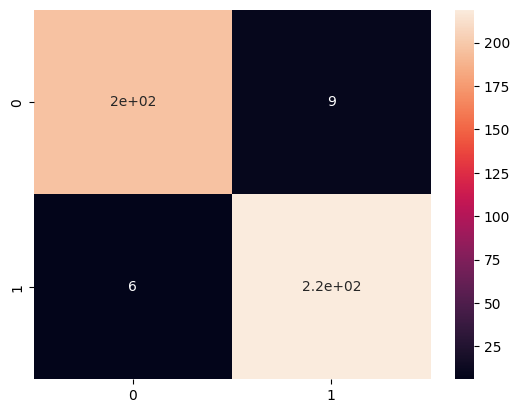

In [22]:
# use C=500 gamma= 0.0001 
pipe.set_params(svc__C=500, svc__gamma=0.0001, svc__kernel='rbf')

pipe.fit(X_train, Y_train)

# Save the model
joblib.dump(pipe, 'model_SVC.pkl')

# Predict on the test set
y_pred = pipe.predict(X_test)

# Evaluate the model
print(confusion_matrix(Y_test, y_pred))
print(classification_report(Y_test, y_pred))
print("Train Accuracy", pipe.score(X_train, Y_train))
print("Test Accuracy", pipe.score(X_test, Y_test))
print("Precision Score", precision_score(Y_test, y_pred))
print("Recall Score", recall_score(Y_test, y_pred))
print("F1 Score", f1_score(Y_test, y_pred))

# Plot confusion matrix

cm = confusion_matrix(Y_test, y_pred)
sns.heatmap(cm, annot=True)
plt.show()


#### Plot the ROC , Precision curves

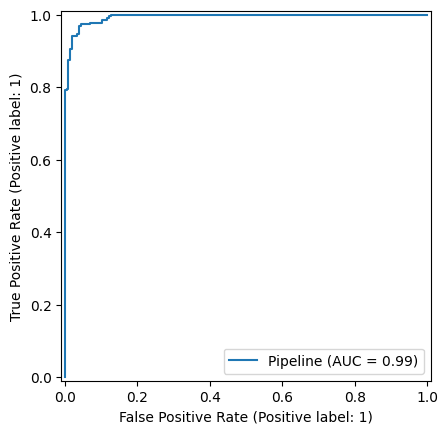

In [24]:
# plot the ROC curve
from sklearn.metrics import RocCurveDisplay
y_score = pipe.decision_function(X_test)
roc_display = RocCurveDisplay.from_estimator(pipe, X_test, Y_test)

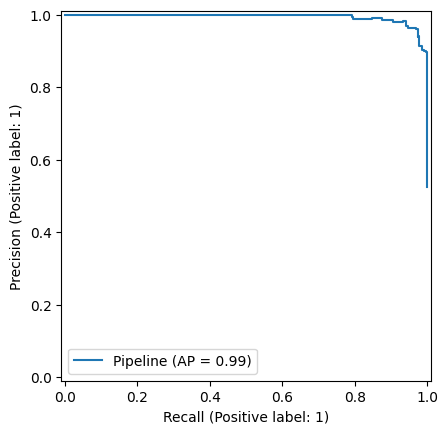

In [25]:
# plot the precision-recall curve
from sklearn.metrics import PrecisionRecallDisplay
pr_display = PrecisionRecallDisplay.from_estimator(pipe, X_test, Y_test)


#### Save the Model

import joblib

joblib.dump(model_SVC, 'svm_model_new.joblib')

#### Load the model and pipeline


In [11]:
# Load the model_SVC.pkl and use the pipeline and predict the test data
pipe_loaded = joblib.load('model_SVC.pkl')

### Test on new Images

In [27]:
def predict_single_image(image_path):
    img = cv2.imread(image_path)

    if np.shape(img) == ():
        return "Invalid Image"

    img = cv2.cvtColor(img, cv2.COLOR_BGR2YCrCb)  # changing to YCrCb color space.
    img_y = img[:, :, 0]  # the Y channel only.
    img_cr = img[:, :, 1]  # the Cr channel only.
    img_cb = img[:, :, 2]  # the Cb channel only.

    Fy = feature_sub_image(img_y)
    Fcr = feature_sub_image(img_cr)
    Fcb = feature_sub_image(img_cb)

    sift_features = extract_sift_features(img)

    final_feature = np.concatenate((Fy[:756], Fcb[:756], Fcr[:756], sift_features[:128]), axis=None)
    final_feature = final_feature.reshape(1, -1)
    
    predictions = pipe_loaded.predict(final_feature)
    probabilities = pipe_loaded.predict_proba(final_feature)
    return predictions, probabilities



In [28]:
image_path = 'Casia1/Au/Au/Au_arc_0084.jpg'
pred, prob = predict_single_image(image_path)
print("Predicted Class:", pred)
print("Probabilities:", prob)

Predicted Class: [0]
Probabilities: [[0.99712911 0.00287089]]


In [29]:
image_path = 'Casia1/Tp/Tp/CM/Sp_S_CND_A_pla0016_pla0016_0196.jpg'
pred, prob = predict_single_image(image_path)
print("Predicted Class:", pred)
print("Probabilities:", prob)

[[ 0.  0.  0. ... 87.  2.  2.]
 [ 4.  4.  6. ... 39. 25.  0.]
 [86. 53. 24. ...  0.  0.  0.]
 ...
 [ 0.  0.  0. ...  0.  0.  0.]
 [ 0.  0.  0. ...  0.  0.  0.]
 [ 0.  0.  0. ...  0.  0.  0.]]
Predicted Class: [1]
Probabilities: [[0.01146502 0.98853498]]


Localization

In [1]:
# import the necessary packages
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet import preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.applications import imagenet_utils
from imutils.object_detection import non_max_suppression
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import pickle
import os
import csv
import argparse
import imutils
import time
import cv2
import joblib

2024-05-01 19:08:48.551571: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-05-01 19:08:49.545762: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [3]:
df=pd.read_csv('CASIA1_features_884.csv')

In [7]:
model1=joblib.load('model_SVC.pkl')

In [8]:
def plt_imshow(title, image):
    # convert the image frame BGR to RGB color space and display it
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    plt.imshow(image)
    plt.title(title)
    plt.grid(False)
    plt.show()

###

In [9]:
def sliding_window(image, step, ws):
    # slide a window across the image
    for y in range(0, image.shape[0] - ws[1], step):
        for x in range(0, image.shape[1] - ws[0], step):
            # yield the current window
            yield (x, y, image[y:y + ws[1], x:x + ws[0]])

In [10]:
def image_pyramid(image, scale=1.5, minSize=(224, 224)):
    # yield the original image
    yield image

    # keep looping over the image pyramid
    while True:
        # compute the dimensions of the next image in the pyramid
        w = int(image.shape[1] / scale)
        image = imutils.resize(image, width=w)

        # if the resized image does not meet the supplied minimum
        # size, then stop constructing the pyramid
        if image.shape[0] < minSize[1] or image.shape[1] < minSize[0]:
            break

        # yield the next image in the pyramid
        yield image

In [11]:
args = {
    "image": "DSCN45tamp133.jpg",
    "size": "(128, 128)",  # roi size
    "min_conf": 0.6,
    "visualize": -1
}

In [12]:
# initialize variables used for the object detection procedure
WIDTH = 600
PYR_SCALE = 1.5
WIN_STEP = 64
ROI_SIZE = eval(args["size"])
INPUT_SIZE = (128, 128)  # input size for the SIFT+HOG based classifier

In [13]:

# load model
with open('model_SVC.pkl', 'rb') as f:
    loaded_classifier = joblib.load(f)

# load classifier
model =  loaded_classifier 

# load the input image from disk, resize it such that it has the
# has the supplied width, and then grab its dimensions
orig = cv2.imread(args["image"])
orig = imutils.resize(orig, width=WIDTH)
(H, W) = orig.shape[:2]

In [14]:
os.getcwd()

'/home/user9/CV_CP'

In [16]:
# initialize the image pyramid
pyramid = image_pyramid(orig, scale=PYR_SCALE, minSize=ROI_SIZE)

# initialize two lists, one to hold the ROIs generated from the image
# pyramid and sliding window, and another list used to store the
# (x, y)-coordinates of where the ROI was in the original image
rois = []
locs = []

# time how long it takes to loop over the image pyramid layers and
# sliding window locations
start = time.time()

In [17]:
import os

# Define the path for the directory
PatchPath = "./RoiPatch"

# Check if the directory exists
if not os.path.exists(PatchPath):
    # Create the directory
    os.makedirs(PatchPath)
    print(f"Directory '{PatchPath}' created.")
else:
    print(f"Directory '{PatchPath}' already exists.")


Directory './RoiPatch' already exists.


In [19]:
PatchPath=r"./RoiPatch"
i=0
# loop over the image pyramidadadaad
for image in pyramid:
    # determine the scale factor between the *original* image
    # dimensions and the *current* layer of the pyramid
    scale = W / float(image.shape[1])

    # for each layer of the image pyramid, loop over the sliding
    # window locations
    for (x, y, roiOrig) in sliding_window(image, WIN_STEP, ROI_SIZE):
        # scale the (x, y)-coordinates of the ROI with respect to the
        # *original* image dimensions
        x = int(x * scale)
        y = int(y * scale)
        w = int(ROI_SIZE[0] * scale)
        h = int(ROI_SIZE[1] * scale)

        # take the ROI and preprocess it so we can later classify
        # the region using Keras/TensorFlow0i7u6yj  
        roi = cv2.resize(roiOrig, INPUT_SIZE)
        roi = img_to_array(roi)
        roi = preprocess_input(roi)

        # update our list of ROIs and associated coordinates
        rois.append(roi)
        #print(rois)
        cv2.imwrite(os.path.join(PatchPath, str(i)+'.jpg'), roi)
        i=i+1
        
        locs.append((x, y, x + w, y + h))
        #print(locs)

        # check to see if we are visualizing each of the sliding windows in the image pyramid
        if args["visualize"] > 0:
            # clone the original image and then draw a bounding box
            # surrounding the current region
            clone = orig.copy()
            cv2.rectangle(clone, (x, y), (x + w, y + h),(0, 255, 0), 2)

            # show the visualization and current ROI
            plt_imshow("Visualization", clone)
            plt_imshow("ROI", roiOrig)

In [20]:
import time

In [21]:
# classify each of the proposal ROIs using SVMS Model and then show how long the classifications took
print("Classifying ROIs")
start = time.time()

test_y_pred = model1.predict(X_test)


# Predict on test set
#y_pred = model1.best_estimator_.predict(X_test)
# Get Probability estimates
probability = model1.predict_proba(X_test)[:, 1]


#test_y_pred
# 0 Kid present
# 1 kid is not present

end = time.time()
#print("[Predication of RoI took {:.5f} seconds".format(end - start))

#print(test_y_pred.shape)
print(len(test_y_pred))

test_y_pred  # label


Classifying ROIs
430


array([0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1,
       1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0,
       1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1,
       0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0,
       1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1,
       0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1,
       0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1,
       0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0,
       1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1,
       1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1,
       1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0,
       1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1,
       0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1,
       0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0,

In [22]:

for x in probability:
    print("{:10.9f}".format(x))

0.065385726
1.000000000
0.000013889
0.002870893
0.000282649
0.042027370
0.999990689
0.017868149
0.743285181
0.954469220
0.996248400
0.948380522
0.067634842
0.042013309
0.001667398
0.983686340
0.808823863
0.160245032
0.000586804
0.919751057
0.007381856
0.990949569
0.986640886
0.923265827
0.960889914
0.995428626
0.999999641
0.570653824
0.014656874
0.918364957
0.943529496
0.018550278
0.911416525
0.908099142
0.312746419
0.951477424
0.856994132
1.000000000
0.001425115
0.000480574
0.000067365
0.999999895
0.034117861
0.180619925
0.900336253
0.999999971
0.983546948
1.000000000
0.336147857
0.011492662
0.290754491
0.012843003
0.860043228
0.135186588
0.948522930
0.025358548
0.994723168
0.132695569
0.000344267
1.000000000
0.926976752
0.995200983
0.999999361
0.003669355
0.000194508
0.986736991
0.006084723
0.000238235
0.999999935
1.000000000
0.173359235
0.595883745
0.018380950
0.995631912
0.000169127
0.999999985
0.000540903
0.995500110
0.997090941
0.982984551
0.925720742
0.941346971
0.910742192
0.00

In [23]:
print(test_y_pred)
print(locs)

[0 1 0 0 0 0 1 0 1 1 1 1 0 0 0 1 1 0 0 1 0 1 1 1 1 1 1 1 0 1 1 0 1 1 0 1 1
 1 0 0 0 1 0 0 1 1 1 1 0 0 0 0 1 0 1 0 1 0 0 1 1 1 1 0 0 1 0 0 1 1 0 1 0 1
 0 1 0 1 1 1 1 1 1 0 1 1 0 0 1 1 0 1 0 1 0 1 1 0 1 0 0 0 0 1 1 0 0 0 1 1 0
 1 0 0 0 0 0 0 0 0 0 1 1 0 0 1 0 1 0 1 0 1 0 1 1 1 1 0 1 1 0 1 0 1 1 1 0 1
 1 0 0 1 0 1 0 0 1 0 0 1 1 0 1 1 1 1 1 1 1 0 0 0 0 0 1 0 1 1 0 1 1 1 0 0 0
 0 1 1 0 1 1 1 0 0 0 1 0 1 1 1 1 0 1 0 1 1 1 1 0 0 1 1 0 0 1 1 0 1 1 1 1 0
 1 1 1 0 0 1 0 0 0 0 1 0 1 0 0 0 1 0 1 0 1 0 1 1 1 0 1 0 1 1 1 0 1 1 1 0 0
 1 1 1 1 1 0 0 0 0 1 1 0 0 1 1 0 1 1 0 1 1 1 1 0 1 0 1 0 0 0 0 0 1 1 1 1 1
 1 0 0 0 0 0 0 1 0 1 1 0 0 0 1 1 1 1 0 1 1 0 0 0 0 1 0 0 0 1 0 1 0 1 0 0 0
 1 0 0 0 1 0 1 0 1 1 1 0 0 1 1 1 1 0 0 1 1 1 0 1 1 0 1 0 0 0 1 0 1 1 1 1 1
 0 0 0 0 0 1 1 1 0 1 0 0 0 0 1 1 0 1 0 0 0 0 1 0 1 1 1 1 1 0 1 1 0 0 0 1 0
 0 1 1 0 1 0 1 0 1 0 1 1 1 1 1 1 0 1 1 0 1 0 1]
[(0, 0, 128, 128), (64, 0, 192, 128), (128, 0, 256, 128), (192, 0, 320, 128), (256, 0, 384, 128), (320, 0, 448, 128), (384, 0, 

In [24]:
for (idx, p) in enumerate(test_y_pred):
    print(probability[0])

0.06538572595472797
0.06538572595472797
0.06538572595472797
0.06538572595472797
0.06538572595472797
0.06538572595472797
0.06538572595472797
0.06538572595472797
0.06538572595472797
0.06538572595472797
0.06538572595472797
0.06538572595472797
0.06538572595472797
0.06538572595472797
0.06538572595472797
0.06538572595472797
0.06538572595472797
0.06538572595472797
0.06538572595472797
0.06538572595472797
0.06538572595472797
0.06538572595472797
0.06538572595472797
0.06538572595472797
0.06538572595472797
0.06538572595472797
0.06538572595472797
0.06538572595472797
0.06538572595472797
0.06538572595472797
0.06538572595472797
0.06538572595472797
0.06538572595472797
0.06538572595472797
0.06538572595472797
0.06538572595472797
0.06538572595472797
0.06538572595472797
0.06538572595472797
0.06538572595472797
0.06538572595472797
0.06538572595472797
0.06538572595472797
0.06538572595472797
0.06538572595472797
0.06538572595472797
0.06538572595472797
0.06538572595472797
0.06538572595472797
0.06538572595472797


In [25]:
labels = {}
args["min_conf"] = 0.6
# loop over the predictions
for (idx, p) in enumerate(test_y_pred):
    #print(probability[idx])
    # grab the prediction information for the current ROI
    #(imagenetID, label, prob) = p[0]
    (label) = p
    # filter out weak detections by ensuring the predicted probability
    # is greater than the minimum probability
    if probability[idx] >= args["min_conf"] and label == 1:
        # grab the bounding box associated with the prediction and
        # convert the coordinates
        if idx<len(locs):
            box = locs[idx]

            # grab the list of predictions for the label and add the
            # bounding box and probability to the list
            L = labels.get(label, [])
            L.append((box, probability[idx]))
            labels[label] = L

print(labels)

{1: [((64, 0, 192, 128), 0.9999999999918582), ((384, 0, 512, 128), 0.9999906889979239), ((0, 64, 128, 192), 0.743285180838031), ((64, 64, 192, 192), 0.9544692197767466), ((128, 64, 256, 192), 0.9962484000095833), ((192, 64, 320, 192), 0.9483805216203272), ((448, 64, 576, 192), 0.9836863399868033), ((0, 128, 128, 256), 0.8088238633525906), ((192, 128, 320, 256), 0.9197510573834946), ((320, 128, 448, 256), 0.9909495694165282), ((384, 128, 512, 256), 0.9866408864880659), ((448, 128, 576, 256), 0.923265826900467), ((0, 192, 128, 320), 0.9608899142909991), ((64, 192, 192, 320), 0.9954286255942688), ((128, 192, 256, 320), 0.9999996405254545), ((320, 192, 448, 320), 0.918364957037394), ((384, 192, 512, 320), 0.9435294964933548), ((0, 256, 128, 384), 0.9114165247898562), ((64, 256, 192, 384), 0.9080991424174056), ((192, 256, 320, 384), 0.9514774238724437), ((256, 256, 384, 384), 0.8569941324705538), ((320, 256, 448, 384), 0.9999999999808306), ((64, 320, 192, 448), 0.9999998947730835), ((256, 3

In [26]:
for label in labels.keys():
    print(label)
    print(labels[label])
    print(len(labels[label]))
    for (box, prob) in labels[label]:
        print(box)
        print(prob)
        print("--------------")
        boxes = np.array([p[0] for p in labels[label]])
        proba = np.array([p[1] for p in labels[label]])
        boxes = non_max_suppression(boxes, proba)
        print(boxes)
        print(proba)
        print("--------------")
        for (startX, startY, endX, endY) in boxes:
            print(startX,"-",startY,"-",endX,"-",endY)
            print("--------------")
            midX = (startX + endX)/2
            midY = (startY + endY)/2
            print(midX,"------",midY)
            

1
[((64, 0, 192, 128), 0.9999999999918582), ((384, 0, 512, 128), 0.9999906889979239), ((0, 64, 128, 192), 0.743285180838031), ((64, 64, 192, 192), 0.9544692197767466), ((128, 64, 256, 192), 0.9962484000095833), ((192, 64, 320, 192), 0.9483805216203272), ((448, 64, 576, 192), 0.9836863399868033), ((0, 128, 128, 256), 0.8088238633525906), ((192, 128, 320, 256), 0.9197510573834946), ((320, 128, 448, 256), 0.9909495694165282), ((384, 128, 512, 256), 0.9866408864880659), ((448, 128, 576, 256), 0.923265826900467), ((0, 192, 128, 320), 0.9608899142909991), ((64, 192, 192, 320), 0.9954286255942688), ((128, 192, 256, 320), 0.9999996405254545), ((320, 192, 448, 320), 0.918364957037394), ((384, 192, 512, 320), 0.9435294964933548), ((0, 256, 128, 384), 0.9114165247898562), ((64, 256, 192, 384), 0.9080991424174056), ((192, 256, 320, 384), 0.9514774238724437), ((256, 256, 384, 384), 0.8569941324705538), ((320, 256, 448, 384), 0.9999999999808306), ((64, 320, 192, 448), 0.9999998947730835), ((256, 320

[INFO] showing results for '1'


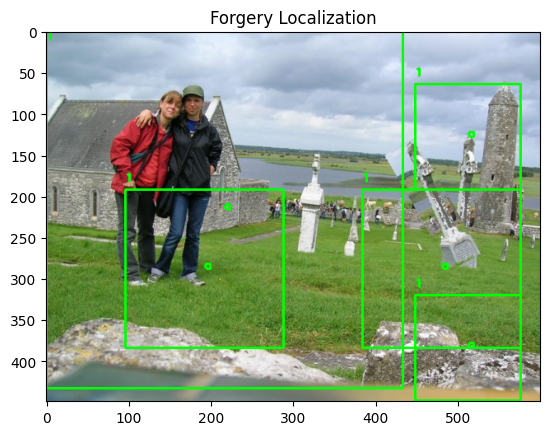

In [29]:
# loop over the labels for each of detected objects in the image

for label in labels.keys():
    # clone the original image so that we can draw on it
    print("[INFO] showing results for '{}'".format(label))
    clone = orig.copy()

    # loop over all bounding boxes for the current label
    for (box, prob) in labels[label]:
        # draw the bounding box on the image
        (startX, startY, endX, endY) = box
        cv2.rectangle(clone, (startX, startY), (endX, endY),
            (0, 255, 0), 2)

    # show the results *before* applying non-maxima suppression, then
    # clone the image again so we can display the results *after*
    # applying non-maxima suppression
    # plt.imshow(clone)
    # plt.title("Before")
    # plt.show()
    clone = orig.copy()

    # extract the bounding boxes and associated prediction
    # probabilities, then apply non-maxima suppression
    boxes = np.array([p[0] for p in labels[label]])
    proba = np.array([p[1] for p in labels[label]])
    boxes = non_max_suppression(boxes, proba)

    # loop over all bounding boxes that were kept after applying
    # non-maxima suppression
    for (startX, startY, endX, endY) in boxes:
        # draw the bounding box and label on the image
        cv2.rectangle(clone, (startX, startY), (endX, endY),(0, 255, 0), 2)
        y = startY - 10 if startY - 10 > 10 else startY + 10
        cv2.putText(clone, str(label), (startX, y),cv2.FONT_HERSHEY_SIMPLEX, 0.45, (0, 255, 0), 2)
        midX = int((startX + endX)/2)
        midY = int((startY + endY)/2)
        cv2.putText(clone, "a", (midX, midY),cv2.FONT_HERSHEY_SIMPLEX, 0.45, (0, 255, 0), 2)
    # show the output after apply non-maxima suppression
    plt_imshow("Forgery Localization", clone)